In [1]:
# Import the required packages
import numpy as np
# from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
# from collections import OrderedDict
import matplotlib.pyplot as plt

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


# RNN Model Class - Conditioning Tasks

In [2]:
class FirstOrderCondRNN(nn.Module):
    def __init__(self, *, n_kc=200, n_mbon=20, n_fbn=60, n_ext=2, n_out=1,
                 T_int=30, T_stim=2, dt=0.5, f_ones=0.1, n_hop=0, n_seed=None):
        super().__init__()

        # Set constants
        W_kc_mbon_max = 0.05
        self.kc_mbon_min = 0.  # Minimum synaptic weight
        self.kc_mbon_max = W_kc_mbon_max  # Maximum synaptic weight
        self.W_kc_mbon_0 = Variable(torch.ones((n_mbon, n_kc)) * W_kc_mbon_max,
                                    requires_grad=False)
        self.tau_w = 5  # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1  # Time scale of output circuitry activity
        self.n_int = 2  # Number of task intervals
        self.T_int = T_int  # Length of task interval [seconds]
        self.T_stim = T_stim  # Length of stimulus presentation [seconds]
        self.dt = dt  # Length of simulation time step [seconds]
        self.n_hop = n_hop

        # Set the sizes of layers
        n_dan = n_mbon
        self.n_kc = n_kc
        self.n_mbon = n_mbon
        self.n_fbn = n_fbn
        self.n_dan = n_dan
        self.n_recur = n_mbon + n_fbn + n_dan
        self.n_ext = n_ext
        self.n_out = n_out
        self.n_ones = int(n_kc * f_ones)

        # Define network variables used to store data
        # Odors
        self.train_odors = None
        self.eval_odors = None
        # Training parameters (for continuation)
        self.train_T_vars = None
        self.train_rts = None
        self.train_Wts = None
        self.train_wts = None
        self.train_vts = None
        self.train_vt_opts = None
        self.train_CS_stim = None
        self.train_US_stim = None
        self.train_loss = None
        # Evaluation parameters (for plotting and analysis)
        self.eval_rts = None
        self.eval_Wts = None
        self.eval_wts = None
        self.eval_vts = None
        self.eval_vt_opts = None
        self.eval_CS_stim = None
        self.eval_US_stim = None
        self.eval_loss = None
        self.eval_err = None

        # Set the seed
        if n_seed is None:
            # self.gen = n_seed
            gen = n_seed
        else:
            np.random.seed(n_seed)
            torch.manual_seed(n_seed)
            gen = torch.Generator()
            gen = gen.manual_seed(n_seed)
            # self.gen = gen

        # Define updatable network parameters
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_mbon = torch.zeros((self.n_recur, n_mbon))
        mean_fbn = torch.zeros((self.n_recur, n_fbn))
        mean_dan = torch.zeros((self.n_recur, n_dan))
        W_mbon = torch.normal(mean_mbon, torch.sqrt(1 / (sqrt2 * n_mbon)),
                              generator=gen)
        W_fbn = torch.normal(mean_fbn, torch.sqrt(1 / (sqrt2 * n_fbn)),
                             generator=gen)
        W_dan = torch.normal(mean_dan, torch.sqrt(1 / (sqrt2 * n_dan)),
                             generator=gen)
        self.W_recur = nn.Parameter(torch.cat((W_mbon, W_fbn, W_dan), dim=1),
                                    requires_grad=True)
        mean_readout = torch.zeros((n_out, n_mbon))
        std_readout = 1 / torch.sqrt(torch.tensor(n_mbon, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout,
                                                   generator=gen),
                                      requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.n_recur) * 0.1,
                                 requires_grad=True)
        # Project the context (ext) signals to the DANs if FBNs are removed
        if n_hop == 1:
            self.W_ext = nn.Parameter(torch.randn(n_dan, n_ext),
                                      requires_grad=True)
        else:
            self.W_ext = nn.Parameter(torch.randn(n_fbn, n_ext),
                                      requires_grad=True)

    def forward(self, r_kc, r_ext, time, n_batch=30, W0=None, r0=None,
                ud_wts=True, ko_wts=None, **kwargs):
        """ Defines the forward pass of the RNN

        The KC->MBON weights are constrained to the range [0, 0.05].
        MBONs receive external input from Kenyon cells (r_kc i.e. 'odors').
        Feedback neurons (FBNs) receive external input (r_ext i.e. 'context').
        DAN->MBON weights are permanently set to zero.
        DANs receive no external input.

        Parameters
            r_kc = activity of the Kenyon cell inputs (representing odors)
            r_ext = context inputs (representing the conditioning context)
            time = time vector for a single interval
            n_batch = number of trials in mini-batch
            W0 = initial weights for KC->MBON connections
            r0 = initial activities for output circuitry neurons
            ud_wts = indicate whether to update dynamic weights
                True: KC->MBON plasticity is on
                False: KC->MBON plasticity turned off
            ko_wts = list of MBON indices to be knocked out

        Returns
            r_recur: list of torch.ndarray(batch_size, n_mbon + n_fbn + n_dan)
                = time series of activities in the output circuitry
            Wt: list of torch.ndarray(batch_size, n_recur, n_recur)
                = time series of KC->MBON weights (dopaminergic plasticity)
            readout: list of torch.ndarray(batch_size, 1)
                = time series of valence readouts (behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        if r0 is not None:
            r_init = r0
        else:
            r_init = torch.ones(n_batch, self.n_recur) * 0.1
            r_init[:, :self.n_mbon] = 0
        r_recur = [r_init]

        # Initialize the eligibility traces and readout
        r_bar_kc = r_kc[:, :, 0]
        r_bar_dan = r_recur[-1][:, -self.n_dan:]
        readout = [torch.einsum('bom, bm -> bo',
                                self.W_readout.repeat(n_batch, 1, 1),
                                r_recur[-1][:, :self.n_mbon]).squeeze()]

        # Clone the readout weight in case it has to be modified
        W_readout = self.W_readout.clone()
        # Set the weights DAN->MBON to zero
        W_recur = self.W_recur.clone()
        if self.n_hop == 0:
            W_recur[:self.n_mbon, -self.n_dan:] = 0
        elif self.n_hop == 1:
            W_recur[:self.n_mbon, -self.n_dan:] = 0
            W_recur[self.n_mbon:(self.n_mbon + self.n_fbn), :] = 0
            W_recur[:, self.n_mbon:(self.n_mbon + self.n_fbn)] = 0
        elif self.n_hop == 2:
            W_recur[:(self.n_mbon + self.n_fbn), -(self.n_dan + self.n_fbn):] = 0
        # Knockout specified weights
        if ko_wts is None:
            ko_wts = []
        for n in ko_wts:
            W_recur[:, n] = 0
            W_readout[:, n] = 0

        # Initialize the KC->MBON weights
        W_kc_mbon = [W0[0]]
        wt = [W0[1]]

        # Update activity for each time step
        for t in range(time.shape[0] - 1):
            # Define the input to the output circuitry
            I_tot = torch.zeros((n_batch, self.n_recur))
            I_kc_mbon = torch.einsum('bmk, bk -> bm',
                                     W_kc_mbon[-1], r_kc[:, :, t])
            I_tot[:, :self.n_mbon] = I_kc_mbon
            # Project the context (ext) signals to the DANs if FBNs are removed
            if self.n_hop == 1:
                I_dan = torch.einsum('bde, be -> bd',
                                     self.W_ext.repeat(n_batch, 1, 1),
                                     r_ext[:, :, t])
                I_tot[:, (self.n_mbon + self.n_fbn):] = I_dan
            else:
                I_fbn = torch.einsum('bfe, be -> bf',
                                     self.W_ext.repeat(n_batch, 1, 1),
                                     r_ext[:, :, t])
                I_tot[:, self.n_mbon:(self.n_mbon + self.n_fbn)] = I_fbn

            # Update the output circuitry activity (see Eq. 1)
            Wr_prod = torch.einsum('bsr, br -> bs',
                                   W_recur.repeat(n_batch, 1, 1),
                                   r_recur[-1])
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(n_batch, 1)
                                        + I_tot)) / self.tau_r
            r_recur.append(r_recur[-1] + dr * dt)

            # Update KC->MBON plasticity variables
            if ud_wts:
                r_dan_dt = r_recur[-1][:, -self.n_dan:]
                wt_out = self.wt_update(W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan,
                                        r_kc[:, :, t], r_dan_dt, n_batch,
                                        **kwargs)
                r_bar_kc, r_bar_dan = wt_out

            # Calculate the readout (see Eq. 2)
            readout.append(torch.einsum('bom, bm -> bo',
                                        W_readout.repeat(n_batch, 1, 1),
                                        r_recur[-1][:, :self.n_mbon]).squeeze())

        return r_recur, (W_kc_mbon, wt), readout

    def wt_update(self, W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan, r_kc, r_dan,
                  n_batch, **kwargs):
        """ Updates the KC->MBON plasticity variables

        Synaptic weights from the Kenyon cells to the mushroom body output neurons
        (MBONs) are updated dynamically. All other weights are network parameters.
        The synaptic connections between Kenyon Cells (KCs) and MBONs are updated
        using a LTP/LTD rule (see Figure 1B of Jiang 2020), which models dopamine-
        gated neural plasticity on short time scale (behavioural learning).

        Parameters
            W_kc_mbon: list = KC->MBON weight matrices
            wt = dynamic plasticity update
            dt = time step of simulation
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch
        """

        # Calculate the eligibility traces (represent LTP/LTD)
        r_bar_kc = r_bar_kc + (r_kc - r_bar_kc) * dt / self.tau_w
        r_bar_dan = r_bar_dan + (r_dan - r_bar_dan) * dt / self.tau_w
        # Update the dynamic weight variable
        dw = self.calc_dw(r_bar_kc, r_bar_dan, r_kc, r_dan, n_batch, **kwargs)
        wt.append(wt[-1] + dw * dt)
        # Update the KC->MBON weights (see Eq. 8)
        dW = (-W_kc_mbon[-1] + wt[-1]) / self.tau_w
        W_tp1 = W_kc_mbon[-1] + dW * dt
        # Clip the KC->MBON weights to the range [0, 0.05]
        W_kc_mbon.append(torch.clamp(W_tp1, self.kc_mbon_min, self.kc_mbon_max))

        return r_bar_kc, r_bar_dan

    def calc_dw(self, r_bar_kc, r_bar_dan, r_kc, r_dan, n_batch, ltp=True,
                **kwargs):
        """ Calculates the dynamic weight update (see Eq 4).

        Parameters
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch
            ltp = indicates whether to include LTP and LTD, or just LTD
                True: calculates both LTD and LTP
                False: only calculates LTD

        Returns
            update to dynamic plasticity variables wt
        """

        # Calculate the LTD/LTP terms
        prod1 = torch.einsum('bd, bk -> bdk', r_bar_dan, r_kc)
        prod2 = torch.einsum('bd, bk -> bdk', r_dan, r_bar_kc)

        if ltp:
            return prod1 - prod2
        else:
            return -prod2

    def run_train(self, opti, *, T_int=None, T_stim=None, dt=None, n_epoch=5000,
                  n_batch=30, reset_wts=True, clip=0.001, **kwargs):
        """ Trains a network on classical conditioning tasks.

        Tasks include first-order or second-order conditioning, and extinction.
        Tasks consist of two (first-order) or three (second-order and extinction)
        intervals. Each task has its own input generating function. Stimuli are
        presented between 5-15s of each interval. Neuron activities are reset
        between intervals to prevent associations being represented through
        persistent activity.

        Parameters
            opti = RNN network optimizer
            T_int = length of task intervals
            T_stim = length of time each stimulus is presented
            dt = time step of simulations
            n_epoch = number of epochs to train over
            n_batch = number of trials in mini-batch
            reset_wts = indicates whether to reset weights between trials
            clip = maximum gradient allowed during training

        Returns
            r_out_epoch = output circuit neuron activities for final epoch
            Wt_epoch = KC->MBON weights for final epoch
            vt_epoch = readout (i.e. valence) for final epoch
            vt_opt = target valence for final epoch
            loss_hist = list of losses for all epochs
            ls_stims = list of stimulus time series for plotting
        """

        # Set the time variables
        if T_int is None:
            T_int = self.T_int
        if T_stim is None:
            T_stim = self.T_stim
        if dt is None:
            dt = self.dt
        time_int = torch.arange(0, T_int + dt / 10, dt)
        T_vars = (T_int, T_stim, dt, time_int.shape[0])
        self.train_T_vars = T_vars[:-1]

        # List to store losses
        loss_hist = []

        # Initialize the KC-MBON weights
        W_in = None

        for epoch in range(n_epoch):
            # Lists to store activities, weights, readouts and target valences
            rts = []
            vts = []

            # Set the intial KC->MBON weight values for each trial
            if reset_wts or (W_in is None):
                W_in = self.init_w_kc_mbon(None, n_batch, (epoch, n_epoch))
            else:
                W_in = (W_in[0][-1].detach(), W_in[1][-1].detach())

            # Generate odor (r_kc), context (r_ext), and target valence (vt_opt)
            net_inputs = self.gen_inputs(T_vars, n_batch, **kwargs)
            # r_kc, r_ext, vt_opt, ls_stims = net_inputs
            r_kc, r_ext, vt_opt = net_inputs

            # For each interval in the task
            for i in range(self.n_int):
                # Run the forward model
                net_out = self(r_kc[i], r_ext[i], time_int, n_batch, W_in)
                rt_int, (Wt_int, wt_int), vt_int = net_out
                # Pass the KC->MBON weights to the next interval
                W_in = (Wt_int[-1], wt_int[-1])

                # Append the interval outputs to lists
                rts += rt_int
                vts += vt_int

            # Convert the list of time point values to a tensor
            #  (time is the last dimension)
            rt_epoch = torch.stack(rts, dim=-1)
            vt_epoch = torch.stack(vts, dim=-1)

            # Calculate the loss
            loss = cond_loss(vt_epoch, vt_opt, rt_epoch[:, -self.n_dan:, :])

            # Update the network parameters
            opti.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), clip)
            opti.step()

            # Print an update
            if epoch % 500 == 0:
                print(epoch, loss.item())
            loss_hist.append(loss.item())

        self.train_loss = loss_hist

        return loss_hist

    def init_w_kc_mbon(self, W_in, n_batch, e_tup):
        """ Initializes the KC->MBON weights for the task.

        KC->MBON weights are reset at the beginning of each epoch.

        Parameters
            W_in = specified initial weight values or None
            n_batch = number of trials in mini-batch
            e_tup: tuple = (current epoch, total training epochs)

        Returns
            tuple of initial KC->MBON and dynamic plasticity variables
        """

        if W_in is None:
            wt0 = self.W_kc_mbon_0.repeat(n_batch, 1, 1)
            W_in = (wt0.clone(), wt0.clone())

        return W_in

    def gen_inputs(self, T_vars, n_batch, p_omit=0.3, **kwargs):
        """ Generates inputs for first-order conditioning tasks.

        All trials are either CS+, CS- (US omitted) or CS omitted (control trials
        to avoid over-fitting). Of the trials where CS or US is omitted, a second
        parameter determines the relative fractions of CS or US trials omitted
        (p_omit_CS). See Fig. 2 of Jiang 2020 to determine sequencing of stimuli
        during training. To account for the sequential nature of numerical
        simulations, the target valence begins one time step after stimulus
        onset. Details provided in Jiang 2020 -> Methods -> Conditioning Tasks.

        The mix of conditions is listed as follows:
            probability of CS+ trials = 1 - p_omit
            probability of CS- trials = p_omit * 0.3
            probability of control trials = p_omit * 0.7

        Parameters
            T_vars: Tuple
                T_vars[0] = T_int = length of trial (in seconds)
                T_vars[1] = T_stim = length of time each stimulus is presented
                T_vars[2] = dt = time step of simulations
                T_vars[3] = time_len = size of time vector
            n_batch = number of trials in mini-batch
            p_omit = probability of omitting either CS or US from trials

        Returns
            r_kct_ls = odor (KC) input time series arrays for each interval
            r_extt_ls = context (ext) input time series arrays for each interval
            vt_opt = target valence for plotting and loss calculations
            ls_stims = stimulus time series for plotting
        """

        # Set the range over which stimuli can be presented
        T_range = (5, 15)
        # Set the time variables
        T_stim, dt, time_len = T_vars[1:]

        # Generate odors and context signals for each trial
        r_kc, r_ext = self.gen_r_kc_ext(n_batch)

        # Determine whether CS or US are randomly omitted
        omit_inds = torch.rand(n_batch) < p_omit
        # If omitted, determine which one is omitted
        p_omit_CS = 0.7
        x_omit_CS = torch.rand(n_batch)
        omit_CS_inds = torch.logical_and(omit_inds, x_omit_CS < p_omit_CS)
        omit_US_inds = torch.logical_and(omit_inds, x_omit_CS > p_omit_CS)

        # Initialize lists to store inputs, target valence
        r_kct_ls = []
        r_extt_ls = []
        vals = []
        # ls_CS = []
        # ls_US = []

        # For each interval
        for i in range(self.n_int):
            # Initialize time matrices
            time_CS = torch.zeros(n_batch, time_len)
            time_US = torch.zeros_like(time_CS)
            val_int = torch.zeros_like(time_CS)

            # Calculate the stimulus presentation times and length
            st_times, st_len = gen_int_times(n_batch, dt, T_stim, T_range)

            for b in range(n_batch):
                stim_inds = st_times[b] + torch.arange(st_len)
                # Set the CS input times
                if not omit_CS_inds[b]:
                    time_CS[b, stim_inds] = 1
                # Set the US input times
                if i == 0 and not omit_US_inds[b]:
                    time_US[b, (stim_inds + st_len)] = 1
                # Set the target valence times
                if i == 1 and not omit_inds[b]:
                    if r_ext[b, 0] == 1:
                        val_int[b, (stim_inds + 1)] = 1
                    elif r_ext[b, 1] == 1:
                        val_int[b, (stim_inds + 1)] = -1

            # Calculate the stimulus time series (KC = CS, ext = US)
            r_kct = torch.einsum('bm, mbt -> bmt', r_kc,
                                 time_CS.repeat(self.n_kc, 1, 1))
            r_extt = torch.einsum('bm, mbt -> bmt', r_ext,
                                  time_US.repeat(self.n_ext, 1, 1))

            r_kct_ls.append(r_kct)
            r_extt_ls.append(r_extt)
            vals.append(val_int)
            # ls_CS += time_CS
            # ls_US += time_US

        # Concatenate target valences
        vt_opt = torch.cat((vals[0], vals[1]), dim=-1)

        # # Make a list of stimulus times to plot
        # ls_stims = [torch.cat(ls_CS), torch.cat(ls_US)]

        # return r_kct_ls, r_extt_ls, vt_opt, ls_stims
        return r_kct_ls, r_extt_ls, vt_opt

    def run_eval(self, trial_fnc, *, T_int=None, T_stim=None, dt=None, n_trial=1,
                 n_batch=1, reset_wts=True, save_data=False, **kwargs):
        """ Runs an evaluation based on a series of input functions

        Parameters
            trial_fnc = function that defines a trial
            T_int = length of a task interval (in seconds)
            T_stim = length of time each stimulus is presented
            dt = time step of simulation (in seconds)
            n_trial = number of trials to run
            n_batch = number of parallel trials in a batch
            reset_wts = indicates whether to reset weights between trials
            save_all_data = save data for each trial, or just the last
        """

        # Reset lists storing evaluation data
        self.eval_rts = []
        self.eval_Wts = []
        self.eval_wts = []
        self.eval_vts = []
        self.eval_vt_opts = []
        self.eval_CS_stim = []
        self.eval_US_stim = []
        self.eval_err = []

        # Set the time variables
        if T_int is None:
            T_int = self.T_int
        if T_stim is None:
            T_stim = self.T_stim
        if dt is None:
            dt = self.dt
        T_vars = (T_int, T_stim, dt)

        # Initialize the KC-MBON weights and plasticity variable
        W_in = None

        # For each trial, run the given trial function
        for trial in range(n_trial):
            # Determine whether to reset KC->MBON weights between trials
            if reset_wts or (W_in is None):
                W_in = self.init_w_kc_mbon(None, n_batch, (trial, n_trial))
            else:
                W_in = (W_in[0][-1].detach(), W_in[1][-1].detach())

            trial_outs = trial_fnc(self, W_in, T_vars, n_batch, **kwargs)
            rts, Wts, wts, vts, vt_opt, err, odors, stim = trial_outs

            # Store the network errors
            self.eval_err.append(err)
            if save_data:
                # Store the network data
                self.eval_rts.append(rts)
                self.eval_Wts.append(Wts)
                self.eval_wts.append(wts)
                self.eval_vts.append(vts)
                self.eval_vt_opts.append(vt_opt)
                self.eval_odors.append(odors)
                # Store the time series lists
                self.eval_CS_stim.append(stim[0])
                self.eval_US_stim.append(stim[1])
            else:
                # Store the network data
                self.eval_rts = [rts]
                self.eval_Wts = [Wts]
                self.eval_wts = [wts]
                self.eval_vts = [vts]
                self.eval_vt_opts = [vt_opt]
                self.eval_odors = [odors]
                # Store the time series lists
                self.eval_CS_stim = [stim[0]]
                self.eval_US_stim = [stim[1]]

    def gen_r_kc_ext(self, n_batch, pos_vt=None, **kwargs):
        """ Generates neuron activations for context and odor inputs.

        Parameters
            n_batch = number of trials in eval-batch
            pos_vt (kwarg) = indicates whether valence should be positive
                             None: random valence
                             True: positive valence
                             False: negative valence
        """

        # Determine the contextual input (r_ext)
        if pos_vt is None:
            r_ext = torch.multinomial(torch.ones(n_batch, self.n_ext),
                                      self.n_ext)
        elif pos_vt:
            r_ext = torch.tensor([1, 0]).repeat(n_batch, 1)
        elif not pos_vt:
            r_ext = torch.tensor([0, 1]).repeat(n_batch, 1)
        else:
            raise Exception('Not a valid value for pos_vt')

        # Determine odor input (r_kc)
        r_kc = torch.zeros(n_batch, self.n_kc)
        for b in range(n_batch):
            # Define an odor (CS) for each trial
            if self.train_odors is not None:
                n_odors = self.train_odors.shape[0]
                odor_select = torch.randint(n_odors, (1,))
                # r_kc_inds = self.train_odors[odor_select, :]
                r_kc[b, :] = self.train_odors[odor_select, :]
            else:
                r_kc_inds = torch.multinomial(torch.ones(self.n_kc), self.n_ones)
                r_kc[b, r_kc_inds] = 1
            # r_kc[b, r_kc_inds] = 1

        return r_kc, r_ext


In [3]:
class NoPlasticityRNN(FirstOrderCondRNN):
    def __init__(self, *, n_odors=10, odor_seed=12345678, **kwargs):
        super().__init__(**kwargs)
        # Set the static KC->MBON weights
        W_kc_mbon_max = 0.05
        self.W_kc_mbon = Variable(torch.rand(self.n_mbon, self.n_kc) *
                                  W_kc_mbon_max, requires_grad=False)
        # Generate a static list of odors for the network to train on
        self.n_odors = n_odors
        gen = torch.Generator()
        gen = gen.manual_seed(odor_seed)
        odor_list = torch.zeros(n_odors, self.n_kc)
        odor_inds = torch.multinomial(torch.ones(n_odors, self.n_kc),
                                      self.n_ones, generator=gen)
        for n in range(n_odors):
            # Define an odor (CS)
            odor_list[n, odor_inds[n, :]] = 1
        self.train_odors = odor_list
        # Set the number of task intervals
        self.n_int = 1

    def wt_update(self, W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan, r_kc, r_dan,
                  n_batch, **kwargs):
        """ Returns directly the static KC->MBON plasticity variables

        Since this class has no plasticity, the KC->MBON weights and plasticity
        variables are not updated. Therefore, the values are returned directly.

        Parameters
            W_kc_MBON: list = KC->MBON weight matrices
            wt = dynamic plasticity update
            dt = time step of simulation
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch
        """

        return r_bar_kc, r_bar_dan

    def gen_inputs(self, T_vars, n_batch, **kwargs):
        """ Generates inputs for task without KC->MBON plasticity.

        All trials are CS+ or control trials where CS+ is switched out for a
        neutral CS in the second presentation (CS- trials). In the case where the
        CS is switched, the target valence is zero. To account for the sequential
        nature of numerical simulations, the target valence is set to begin one
        time step after stimulus onset.

        The mix of conditions is listed as follows:
            probability of trials where CS+ is switched = 0.5

        Parameters
            T_vars: Tuple
                T_vars[0] = T_int = length of trial (in seconds)
                T_vars[1] = T_stim = length of time each stimulus is presented
                T_vars[2] = dt = time step of simulations
                T_vars[3] = time_len = size of time vector
            n_batch = number of trials in mini-batch
            p_omit = probability of omitting either CS or US from trials

        Returns
            r_kct_ls = odor (KC) input time series arrays for each interval
            r_extt_ls = context (ext) input time series arrays for each interval
            vt_opt = target valence for plotting and loss calculations
            ls_stims = stimulus time series for plotting
        """

        # Set the range over which stimuli can be presented
        T_range = [(5, 15), (20, 30)]
        # Set the time variables
        T_stim, dt, time_len = T_vars[1:]

        # Generate odors and context signals for each trial
        r_kc, r_ext = self.gen_r_kc_ext(n_batch, **kwargs)

        # Determine whether CS2+ is switched (switch on half of trials)
        switch_inds = torch.rand(n_batch) < 0.5

        # Initialize activity matrices
        r_kct = torch.zeros(n_batch, self.n_kc, time_len)
        r_extt = torch.zeros(n_batch, self.n_ext, time_len)

        # Initialize valence matrix
        vt_opt = torch.zeros(n_batch, time_len)
        # time_US = torch.zeros_like(vt_opt)
        # time_CS_both = torch.zeros_like(vt_opt)

        # For each stimulus presentation
        for i in range(2):
            # Initialize time matrices
            time_CS = torch.zeros_like(vt_opt)
            time_US = torch.zeros_like(vt_opt)

            # Calculate the stimulus presentation times and length
            st_times, st_len = gen_int_times(n_batch, dt, T_stim, T_range[i])

            for b in range(n_batch):
                # if i == 0:
                #     print((r_kc[b, :] == 1).nonzero().squeeze())
                #
                stim_inds = st_times[b] + torch.arange(st_len)
                # Set the CS time
                time_CS[b, stim_inds] = 1
                # Set the US time
                if i == 0:
                    time_US[b, stim_inds + st_len] = 1
                # Set the CS+/CS2 and target valence times
                if i == 1:
                    # Switch the odor in half the trials (target valence is zero)
                    if switch_inds[b]:
                        CS2_inds = torch.multinomial(torch.ones(self.n_kc),
                                                     self.n_kc)
                        r_kc[b, :] = r_kc[b, CS2_inds]
                        r_ext[b, :] = 0
                    # If the odor is not switched, set the target valence
                    else:
                        if r_ext[b, 0] == 1:
                            vt_opt[b, (stim_inds + 1)] = 1
                        elif r_ext[b, 1] == 1:
                            vt_opt[b, (stim_inds + 1)] = -1

            # Calculate the stimulus time series (KC = CS, ext = US)
            r_kct += torch.einsum('bm, mbt -> bmt', r_kc,
                                  time_CS.repeat(self.n_kc, 1, 1))
            r_extt += torch.einsum('bm, mbt -> bmt', r_ext,
                                   time_US.repeat(self.n_ext, 1, 1))
            # time_CS_both += time_CS

        # # Make a list of stimulus times to plot
        # ls_stims = [time_CS_both, time_US]

        # return [r_kct], [r_extt], vt_opt, ls_stims
        return [r_kct], [r_extt], vt_opt

    def init_w_kc_mbon(self, W_in, n_batch, e_tup):
        """ Initializes the KC->MBON weights for the task.

        KC->MBON weights are reset at the beginning of each epoch.

        Parameters
            W_in = specified initial weight values or None
            n_batch = number of trials in mini-batch
            e_tup: tuple = (current epoch, total training epochs)

        Returns
            tuple of initial KC->MBON and dynamic plasticity variables
        """

        if W_in is None:
            wt0 = self.W_kc_mbon.repeat(n_batch, 1, 1)
            W_in = (wt0.clone(), wt0.clone())

        return W_in

# test_RNN = NoPlasticityRNN(n_odors=10)
# print(test_RNN.W_KC_MBON.shape)


In [4]:
def cond_err(vt, vt_opt):
    """ Calculates the readout error for conditioning tasks.

    Only accounts for error due to difference between target (optimal) readout
    and the MBON readout scalar.

    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)

    Returns
        vt_loss = scalar readout error used in evaluation
    """

    # Calculate the MSE loss of the valence
    vt_loss = torch.mean((vt - vt_opt) ** 2)

    return vt_loss


def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.

    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eqs. (3) and (9) in Jiang 2020.

    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant

    Returns
        loss_tot = scalar loss used in backprop
    """

    # Set the baseline DAN activity
    DAN_baseline = 0.1

    # Calculate the MSE loss of the valence (scalar)
    vt_loss = cond_err(vt, vt_opt)

    # Calculate DAN activity regularization term (scalar)
    rt_sum = torch.sum(F.relu(r_DAN - DAN_baseline) ** 2, dim=1)
    rt_loss = torch.mean(rt_sum) * lam

    # Calculate the combined loss
    loss = vt_loss + rt_loss

    return loss


def gen_int_times(n_batch, dt, T_stim, T_range=(5, 15), **kwargs):
    """ Generates an array of stimulus presentation times for all trials

    Parameters
        dt = time step of simulations
        n_batch = number of trials in eval-batch
        T_stim = length of time each stimulus is presented
        T_range: tuple = range in which stimulus can be presented

    Returns
        st_times = array of stimulus presentation times for each trial
        stim_len = length of stimulus presentation (in indices)
    """

    # Present the stimulus between 5-15s of each interval
    min_ind = int(T_range[0] / dt)
    max_ind = int((T_range[1] - 2 * T_stim) / dt)
    st_times = torch.randint(min_ind, max_ind, (n_batch,))
    st_len = int(T_stim / dt)

    return st_times, st_len


In [5]:
# def print_trial(network, task1:str, task2:str, dt=0.5):
def print_trial(network, optimizer, task, n_odors=10, dt=0.5):
    """ Plots a figure similar to Figure 2 from Jiang 2020.
    
    Runs the network using a novel combination of conditioned and unconditioned stimuli,
    then prints the results. Top: time series of the various stimuli (CS and US), as well as
    the target valence and readout. Bottom: activity of eight randomly chosen mushroom body
    output neurons (MBONs).
    
    Paramters
        network = previously trained RNN
        task = the type of task to be plotted ('CS+' or 'CS2')
        dt = time step of the simulation/plot
    """
    
    # Set the labels for the plots
    if task == 'CS+':
        task_title = 'First-Order Conditioning'
    elif task == 'CS2':
        task_title = 'CS+ Generalization'
    
    # Define plot font sizes
    label_font = 18
    title_font = 24
    legend_font = 12

    # Run the network
    r_out, vt, vt_opt, loss_hist, stim_ls = network.train_net(opti=optimizer, dt=dt, n_epoch=1, n_batch=1, n_odors=n_odors)
    r_out = r_out.detach().numpy().squeeze()
    vt = vt.detach().numpy().squeeze()
    vt_opt = vt_opt.detach().numpy().squeeze()
    plot_CS = stim_ls[0].numpy().squeeze()
    plot_US = stim_ls[1].numpy().squeeze()
    plot_time = np.arange(plot_CS.size) * dt

    # Plot the conditioning and test
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    ax1.plot(plot_time, vt, label='Readout')
    ax1.plot(plot_time, vt_opt, label='Target')
    # Second-order conditioning involves an additional stimulus time series
    if task == 'CS+':
        ax1.plot(plot_time, plot_CS, label=task)
    else:
        half_ind = plot_time.size // 2
        plot_CSp = np.zeros(plot_time.size)
        plot_CSp[:half_ind] = plot_CS[:half_ind]
        plot_CS2 = np.zeros(plot_time.size)
        plot_CS2[half_ind:] = plot_CS[half_ind:]
        ax1.plot(plot_time, plot_CSp, label='CS+')
        ax1.plot(plot_time, plot_CS2, label=task)
    ax1.plot(plot_time, plot_US, label='US')
    ax1.set_ylabel('Value', fontsize=label_font)
    ax1.set_title(task_title, fontsize=title_font)
    ax1.legend(fontsize=legend_font)

    # Plot the activities of a few MBONs
    plot_neurs = np.random.choice(network.N_MBON, size=8, replace=False)
    r_max = np.max(r_out)
    for i, n in enumerate(plot_neurs):
        ax2.plot(plot_time, (r_out[n, :] / r_max) + (i * 2 / 3), '-k')
    ax2.set_xlabel('Time', fontsize=label_font)
    ax2.set_ylabel('Normalized Activity', fontsize=label_font)
    ax2.set_yticks([])
    fig.tight_layout();
    

In [6]:
# Initialize the network
# classic_net = DrosophilaRNN()
classic_net = NoPlasticityRNN(n_odors=1)
# classic_net = NoPlasticityRNN(n_odors=1)
for param in classic_net.parameters():
    print(param.shape)
#     print(param)
# print(classic_net.N_DAN)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(classic_net.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100])
torch.Size([60, 2])


In [7]:
train_bool = True
if train_bool:
#     r_out, vt, vt_opt, loss_hist, _ = classic_net.train_net(opti=optimizer, n_epoch=2000, n_odors=1)
    loss_hist = classic_net.run_train(opti=optimizer, n_epoch=5000)


0 307.5860900878906
500 0.014365077950060368
1000 0.010001723654568195
1500 0.010060250759124756
2000 0.00676898006349802
2500 0.004844062030315399
3000 0.004785757511854172
3500 0.005294321570545435
4000 0.004724365193396807
4500 0.003908597398549318


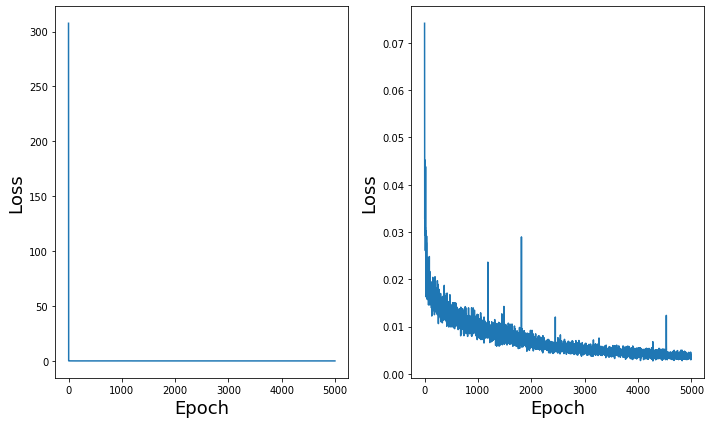

In [8]:
if train_bool:
    # Plot the loss function
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(loss_hist)
    axes[0].set_xlabel('Epoch', fontsize=label_font)
    axes[0].set_ylabel('Loss', fontsize=label_font)
    axes[1].plot(loss_hist[5:])
    axes[1].set_xlabel('Epoch', fontsize=label_font)
    axes[1].set_ylabel('Loss', fontsize=label_font)
    fig.tight_layout();


In [13]:
torch.save(classic_net.state_dict(), 'trained_no_plasticity_10odor_5000ep.pt')

# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
# https://pytorch.org/tutorials/beginner/saving_loading_models.html


In [10]:
# Plot some results to compare to Fig 2A/B in paper
if not train_bool:
#     classic_net.load_state_dict(torch.load('trained_N5_no_plasticity_10odor_2000epochs.pt'))
#     classic_net.load_state_dict(torch.load('trained_N6_no_plasticity_1odor_2000epochs.pt'))
    classic_net.eval()

# print_trial(classic_net, optimizer, task='CS+')
# print_trial(classic_net, task='CS2')


In [11]:
# r_out, Wt, vt, vt_opt, loss_hist, _ = train_net(classic_net, task=train_task, n_epochs=200, train=False)
loss_hist = classic_net.run_train(opti=optimizer, n_epoch=200)
print(np.mean(loss_hist), np.std(loss_hist))


0 0.0039345091208815575
0.0037157740804832427 0.0004360443604457427
